In [ ]:
import os
import random
import re
import string
from collections import Counter

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download("stopwords")

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

import networkx as nx
import plotly.express as px
import plotly.graph_objects as go

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

Error: Canceled future for execute_request message before replies were done

In [250]:
df = pd.read_csv('./data/new_papers.csv')
df = df.drop_duplicates()
print(df.shape)
df.head()

(49296, 5)


Conference  Year                                              Title  \
0    NeurIPS  2006  Attentional Processing on a Spike-Based VLSI N...   
1    NeurIPS  2006  Attentional Processing on a Spike-Based VLSI N...   
2    NeurIPS  2006  Attentional Processing on a Spike-Based VLSI N...   
3    NeurIPS  2006                        Multi-Task Feature Learning   
4    NeurIPS  2006                        Multi-Task Feature Learning   

             Author                                        Affiliation  
0      Yingxue Wang      Swiss Federal Institute of Technology, Zurich  
1  Rodney J Douglas                      Institute of Neuroinformatics  
2     Shih-Chii Liu  Institute for Neuroinformatics, University of ...  
3  Andreas Argyriou                            Ecole Centrale de Paris  
4    Theos Evgeniou                                             INSEAD

In [251]:
data = df['Title'].explode().unique()
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
tagged_data[:5]

[TaggedDocument(words=['attentional', 'processing', 'on', 'a', 'spike-based', 'vlsi', 'neural', 'network'], tags=['0']),
 TaggedDocument(words=['multi-task', 'feature', 'learning'], tags=['1']),
 TaggedDocument(words=['a', 'rate-distortion', 'approach', 'to', 'joint', 'pattern', 'alignment'], tags=['2']),
 TaggedDocument(words=['context', 'effects', 'in', 'category', 'learning', ':', 'an', 'investigation', 'of', 'four', 'probabilistic', 'models'], tags=['3']),
 TaggedDocument(words=['comparative', 'gene', 'prediction', 'using', 'conditional', 'random', 'fields'], tags=['4'])]

In [7]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm = 0)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

In [8]:
# model.save("./assets/d2v.model")
# print("Model Saved")
# temp = model

In [11]:
model= Doc2Vec.load("./assets/d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.dv.most_similar('1')
print(similar_doc)

# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.dv['1'])

V1_infer [-0.10585925 -0.04179908  0.13316105 -0.12083445 -0.0337358  -0.00112639
 -0.11845717 -0.07163564 -0.05492446  0.0120047  -0.00688153  0.11670046
 -0.04659327  0.15545022  0.03872882 -0.03856474 -0.02000322 -0.07554708
 -0.01512764 -0.06835733]
[('4147', 0.9009073972702026), ('8986', 0.8515761494636536), ('2165', 0.839266836643219), ('11669', 0.8338145017623901), ('1896', 0.8334353566169739), ('5366', 0.8333684206008911), ('4845', 0.8328126668930054), ('1705', 0.8322224020957947), ('12425', 0.830976665019989), ('1414', 0.8302884101867676)]
[-1.1511896  -0.8862417   1.136339   -0.4533122   0.6660761  -0.70663875
  0.6818575  -0.5741899   0.3944933   0.4704267   0.8484096   0.36100903
  0.0593525   2.1841767   0.2276707  -0.5585859   0.07464463 -0.7543868
  0.2710258   1.122398  ]


In [12]:
model.wv.index_to_key[:5]

['for', 'learning', ':', 'of', 'with']

In [13]:
title_embeddings = []
# for i in range(len(model.docvecs)):
for i in range(100):
  temp = model.dv[i]
  title_embeddings.append(temp)
title_embeddings = np.array(title_embeddings)

In [14]:
print(type(title_embeddings))
print(type(title_embeddings[0]))
title_embeddings[:2]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([[-0.44085518,  1.2876868 ,  1.0149361 , -1.5619195 ,  0.71958053,
        -0.7046075 , -3.1385162 , -0.8460909 ,  0.29075068, -2.729757  ,
        -1.9066424 ,  1.0171617 ,  2.1519902 ,  3.2519345 ,  0.7662354 ,
         0.09284754, -0.19611257, -1.0221146 ,  0.07754012,  1.0171894 ],
       [-1.1511896 , -0.8862417 ,  1.136339  , -0.4533122 ,  0.6660761 ,
        -0.70663875,  0.6818575 , -0.5741899 ,  0.3944933 ,  0.4704267 ,
         0.8484096 ,  0.36100903,  0.0593525 ,  2.1841767 ,  0.2276707 ,
        -0.5585859 ,  0.07464463, -0.7543868 ,  0.2710258 ,  1.122398  ]],
      dtype=float32)

In [15]:
similarity_matrix = cosine_similarity(title_embeddings)
print(similarity_matrix.shape)

(100, 100)


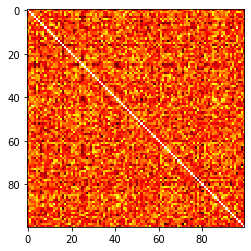

In [16]:
a = similarity_matrix
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

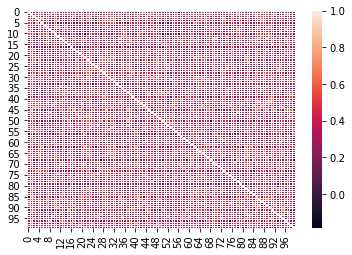

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

uniform_data = similarity_matrix
ax = sns.heatmap(uniform_data, linewidth=0.5)
plt.show()

In [18]:
# create nx graph from sim matrix
G = nx.to_networkx_graph(similarity_matrix)

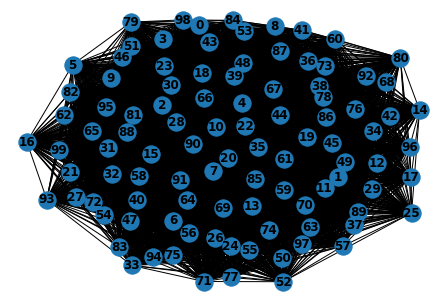

In [19]:
# nx.draw(G, with_labels=True, font_weight='bold')
nx.draw(G)

In [20]:
def create_node_trace(G):
    # collect node information from G to plot
    node_x = []
    node_y = []
    node_text = []
    node_color = []

    for i, node in enumerate(G.nodes(data=True)):
        # get node x,y position and store
        x, y = node[1]['pos']
        node_x.append(x)
        node_y.append(y)

        node_text.append(node[1]['text'])
        node_color.append(node[1]['color'])

    # create node trace (i.e., scatter plot)
    # make it invisible by default
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=False,
            color=node_color,
            size=16,
            line_width=0.5,
        ),
        text=node_text,
        visible=False
    )

    return node_trace

In [21]:
def create_edge_trace(G):
    # collect edges information from G to plot
    edge_weight = []
    edge_text = []
    edge_pos = []
    edge_color = []
    
    for edge in G.edges(data=True):
        
        # edge is line connecting two points
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_pos.append([[x0, x1, None], [y0, y1, None]])
        
        # edge line color when drawn
        edge_color.append("black")

    # there is a trace for each edge
    edge_traces = []
    for i in range(len(edge_pos)):
        
        # edge line width
        line_width = 1

        # is scatter because it is line connecting two points
        trace = go.Scatter(
            x=edge_pos[i][0], y=edge_pos[i][1],
            line=dict(width=line_width, color=edge_color[i]),
            mode='lines',
            visible=False
        )
        edge_traces.append(trace)

    return edge_traces

In [22]:
def filter_similarity_matrix_at_step(square_matrix, step_value):
    # copy matrix
    aux = square_matrix.copy()
    
    # set as NaN all values equal to or below threshold value
    aux[aux <= step_value] = np.nan
    
    # return filtered matrix
    return aux

In [23]:
def get_interactive_slider_similarity_graph(square_matrix, slider_values, node_text=None, yaxisrange=None, xaxisrange=None):
    
    # Create figure with plotly
    fig = go.Figure()

    # key: slider value
    # value: list of traces to display for that slider value
    slider_dict = {}
    
    # total number of traces
    total_n_traces = 0
    
    # node positions on plot
    #node_pos = None

    # for each possible value in the slider, create and store traces (i.e., plots)
    for i, step_value in enumerate(slider_values):

        # update similarity matrix for the current step
        aux = filter_similarity_matrix_at_step(square_matrix, step_value)

        # create nx graph from sim matrix
        G = nx.to_networkx_graph(aux)
        
        # remove edges for 0 weight (NaN)
        G.remove_edges_from([(a, b) for a, b, attrs in G.edges(data=True) if np.isnan(attrs["weight"])])

        # assign node positions if None
        node_pos = nx.nx_pydot.graphviz_layout(G)

        # populate nodes with meta information
        for node in G.nodes(data=True):
            
            # node position
            node[1]['pos'] = node_pos[node[0]]

            # node color
            node[1]['color'] = "orange"

            # node text on hover if any is specified else is empty
            if node_text is not None:
                node[1]['text'] = node_text[node[0]]
            else:
                node[1]['text'] = ""

        # create edge taces (each edge is a trace, thus this is a list)
        edge_traces = create_edge_trace(G)
        
        # create node trace (a single trace for all nodes, thus it is not a list)
        node_trace = create_node_trace(G) 

        # store edge+node traces as single list for the current step value
        slider_dict[step_value] = edge_traces + [node_trace]
        
        # keep count of the total number of traces
        total_n_traces += len(slider_dict[step_value])

        # make sure that the first slider value is active for visualization
        if i == 0:
            for trace in slider_dict[step_value]:
                # make visible
                trace.visible = True

                
    # Create steps objects (one step per step_value)
    steps = []
    for step_value in slider_values:
        
        # count traces before adding new traces
        n_traces_before_adding_new = len(fig.data)
        
        # add new traces
        fig.add_traces(slider_dict[step_value])

        step = dict(
            # update figure when this step is active
            method="update",
            # make all traces invisible
            args=[{"visible": [False] * total_n_traces}],
            # label on the slider
            label=str(round(step_value, 3)),
        )

        # only toggle this step's traces visible, others remain invisible
        n_traces_for_step_value = len(slider_dict[step_value])
        for i in range(n_traces_before_adding_new, n_traces_before_adding_new + n_traces_for_step_value):
            step["args"][0]["visible"][i] = True
        
        # store step object in list of many steps
        steps.append(step)

    # create slider with list of step objects
    slider = [dict(
        active=0,
        steps=steps
    )]

    # add slider to figure and create layout
    fig.update_layout(
        sliders=slider,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(range=xaxisrange, showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(range=yaxisrange, showgrid=False, zeroline=False, showticklabels=False),
        width=700, height=700,
    )

    return fig

In [25]:
# define slider steps (i.e., threshold values)
slider_steps = np.arange(0.4, 0.85, 0.05)
    
# get the slider figure
fig = get_interactive_slider_similarity_graph(
    similarity_matrix,
    slider_steps,
    node_text = data
)

# plot it
fig.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MAHIKA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [197]:
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

In [198]:
df_raw = pd.read_csv('./data/new_papers.csv')
df_raw = df_raw.drop_duplicates()

custom_stopwords = set(stopwords.words("english"))
text_columns = ["Title"]

df = df_raw.copy()

for col in text_columns:
    df[col] = df[col].astype(str)

# Create text column based on title, description, and content
df["text"] = df[text_columns].apply(lambda x: " | ".join(x), axis=1)
df["tokens"] = df["text"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))

# Remove duplicated after preprocessing
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

# Remove empty values and keep relevant columns
df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["text", "tokens", "Year", "Conference"]]

print(f"Original dataframe: {df_raw.shape}")
print(f"Pre-processed dataframe: {df.shape}")

Original dataframe: (49296, 5)
Pre-processed dataframe: (13262, 4)


In [199]:
docs = df["text"].values
tokenized_docs = df["tokens"].values

In [200]:
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=SEED)

In [201]:
model.wv.most_similar("neuron")

[('dependent', 0.9991003274917603),
 ('single', 0.9990434050559998),
 ('human', 0.9990330934524536),
 ('perspective', 0.9990317225456238),
 ('partial', 0.9989955425262451),
 ('nonlinear', 0.9989703297615051),
 ('gan', 0.9989668726921082),
 ('automatic', 0.9989627599716187),
 ('wasserstein', 0.9989594221115112),
 ('better', 0.9989517331123352)]

In [202]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(tokenized_docs, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(13262, 100)

In [203]:
print(type(vectorized_docs[0]))
print(type(vectorized_docs))

<class 'numpy.ndarray'>
<class 'list'>


In [204]:
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [205]:
clustering, cluster_labels = mbkmeans_clusters(
	X=vectorized_docs,
    k=20,
    mb=500,
    print_silhouette_values=True,
)

D:\Software\Anaconda\envs\cs328_writing_new\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=2



For n_clusters = 20
Silhouette coefficient: 0.19
Inertia:220.08223956833447
Silhouette values:
    Cluster 11: Size:296 | Avg:0.43 | Min:-0.03 | Max: 0.63
    Cluster 5: Size:50 | Avg:0.41 | Min:-0.04 | Max: 0.61
    Cluster 4: Size:627 | Avg:0.32 | Min:-0.02 | Max: 0.57
    Cluster 7: Size:222 | Avg:0.26 | Min:-0.11 | Max: 0.52
    Cluster 13: Size:483 | Avg:0.25 | Min:-0.08 | Max: 0.53
    Cluster 16: Size:1058 | Avg:0.21 | Min:-0.09 | Max: 0.45
    Cluster 6: Size:510 | Avg:0.21 | Min:-0.14 | Max: 0.52
    Cluster 14: Size:1150 | Avg:0.21 | Min:0.01 | Max: 0.44
    Cluster 1: Size:1225 | Avg:0.19 | Min:-0.06 | Max: 0.43
    Cluster 0: Size:1005 | Avg:0.18 | Min:-0.02 | Max: 0.41
    Cluster 18: Size:1164 | Avg:0.18 | Min:-0.08 | Max: 0.44
    Cluster 2: Size:259 | Avg:0.17 | Min:-0.12 | Max: 0.45
    Cluster 17: Size:904 | Avg:0.17 | Min:-0.05 | Max: 0.40
    Cluster 8: Size:732 | Avg:0.16 | Min:-0.08 | Max: 0.41
    Cluster 10: Size:577 | Avg:0.16 | Min:-0.09 | Max: 0.41
    Cluste

In [206]:
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels,
    "vectorized_docs": vectorized_docs,
    "year": list(df['Year']),
    "conference": list(df['Conference'])
})

In [207]:
df_clusters.head()

text  \
0        On 1/n neural representation and robustness   
1  Do 2D GANs Know 3D Shape? Unsupervised 3D Shap...   
2   3D-Aware Scene Manipulation via Inverse Graphics   
3     3D Gaze Concurrences from Head-mounted Cameras   
4  3D Multi-bodies: Fitting Sets of Plausible 3D ...   

                                              tokens  cluster  \
0                1n neural representation robustness        7   
1  2d gans know 3d shape unsupervised 3d shape re...       14   
2   3d aware scene manipulation via inverse graphics       14   
3          3d gaze concurrences head mounted cameras       16   
4  3d multi bodies fitting sets plausible 3d huma...       10   

                                     vectorized_docs  year conference  
0  [0.056133837, -0.010953411, -0.18008822, 0.063...  2020    NeurIPS  
1  [0.04935929, -0.04940794, -0.12340832, 0.04383...  2021       ICLR  
2  [0.048220705, -0.045804773, -0.12345145, 0.046...  2018    NeurIPS  
3  [0.037655167, -0.04429528, -0.09770333, 0.0377...  2012    NeurIPS  
4  [0.061576527, -0.06371212, -0.14973295, 0.0626...  2020    NeurIPS

In [208]:
import matplotlib.pyplot as plt

In [209]:
pca = PCA(2)
#Transform the data
pca_vectorized_docs = pca.fit_transform(vectorized_docs)

In [210]:
pca_vectorized_docs[:5]

array([[-0.64024568,  0.37575731],
       [ 0.13994327,  0.04562862],
       [ 0.16878082,  0.02253613],
       [ 0.46633374,  0.04214169],
       [-0.27404313,  0.04920894]])

In [211]:
df_clusters['pca_vectorized_docs'] = list(pca_vectorized_docs)
df_clusters.head()

text  \
0        On 1/n neural representation and robustness   
1  Do 2D GANs Know 3D Shape? Unsupervised 3D Shap...   
2   3D-Aware Scene Manipulation via Inverse Graphics   
3     3D Gaze Concurrences from Head-mounted Cameras   
4  3D Multi-bodies: Fitting Sets of Plausible 3D ...   

                                              tokens  cluster  \
0                1n neural representation robustness        7   
1  2d gans know 3d shape unsupervised 3d shape re...       14   
2   3d aware scene manipulation via inverse graphics       14   
3          3d gaze concurrences head mounted cameras       16   
4  3d multi bodies fitting sets plausible 3d huma...       10   

                                     vectorized_docs  year conference  \
0  [0.056133837, -0.010953411, -0.18008822, 0.063...  2020    NeurIPS   
1  [0.04935929, -0.04940794, -0.12340832, 0.04383...  2021       ICLR   
2  [0.048220705, -0.045804773, -0.12345145, 0.046...  2018    NeurIPS   
3  [0.037655167, -0.04429528, -0.09770333, 0.0377...  2012    NeurIPS   
4  [0.061576527, -0.06371212, -0.14973295, 0.0626...  2020    NeurIPS   

                           pca_vectorized_docs  
0   [-0.6402456765834895, 0.37575730615900593]  
1   [0.13994327032482898, 0.04562862255198789]  
2  [0.16878081554976784, 0.022536134625836996]  
3     [0.466333744770643, 0.04214169085590727]  
4  [-0.27404312676356285, 0.04920893984190434]

In [212]:
df_clusters['year'].value_counts()

2020    2982
2019    2701
2018    1966
2017    1113
2021     859
2016     568
2014     411
2015     403
2012     368
2013     360
2011     306
2010     292
2009     262
2008     250
2007     217
2006     204
Name: year, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


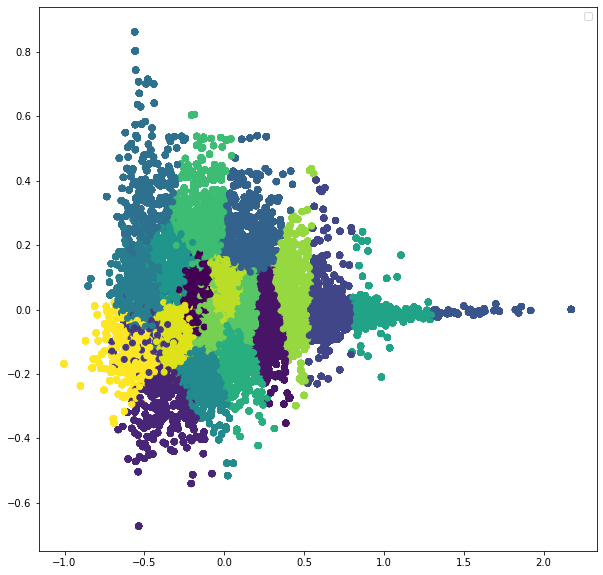

In [213]:
def Extract(lst, i):
    return [item[i] for item in lst]

# Getting unique labels
u_labels = np.unique(df_clusters['cluster'])

# plotting the results:

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

for i in u_labels:
    plt.scatter(Extract(df_clusters['pca_vectorized_docs'], 0), Extract(df_clusters['pca_vectorized_docs'],1) , c = df_clusters['cluster'])
plt.legend()
plt.show()

In [ ]:
# Getting unique labels
u_labels = np.unique(df_clusters['cluster'])

# plotting the results:

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

for curr_year in range(2006,2021):
    temp_df_clusters = df_clusters[df_clusters['year']==curr_year]
    for i in u_labels:
        plt.scatter(Extract(temp_df_clusters['pca_vectorized_docs'], 0), Extract(temp_df_clusters['pca_vectorized_docs'],1) , c = temp_df_clusters['cluster'])
    plt.legend()
    plt.show()

In [215]:
print("Most representative terms per cluster (based on centroids):")
cluster_terms_dict = {}
for i in range(20):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")
    cluster_terms_dict[i] = tokens_per_cluster


Most representative terms per cluster (based on centroids):
Cluster 0: view approach embedding joint human 
Cluster 1: application estimating without partial general 
Cluster 2: accelerated convergence methods method coordinate 
Cluster 3: mixture variable dirichlet map mixtures 
Cluster 4: weight human dynamics scalable partial 
Cluster 5: application human single dependent estimating 
Cluster 6: network training graph attention equivariant 
Cluster 7: graph network recurrent training convolutional 
Cluster 8: view approach knowledge embedding joint 
Cluster 9: algorithm method adaptive proximal problems 
Cluster 10: attention understanding aware uncertainty nets 
Cluster 11: single human gans application dynamics 
Cluster 12: faster parallel greedy fast regularized 
Cluster 13: network training graph generative recurrent 
Cluster 14: human scalable joint partial embedding 
Cluster 15: scalable estimating application partial distributions 
Cluster 16: weight human dynamics uncertainty

In [216]:
df_clusters['cluster_terms'] = [0]*df_clusters.shape[0]
for index, row in df_clusters.iterrows():
    df_clusters['cluster_terms'][index] = cluster_terms_dict[row['cluster']]

C:\Users\MAHIKA\AppData\Local\Temp\ipykernel_8260\3382901888.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [219]:
cluster_terms_dict

{0: 'view approach embedding joint human ',
 1: 'application estimating without partial general ',
 2: 'accelerated convergence methods method coordinate ',
 3: 'mixture variable dirichlet map mixtures ',
 4: 'weight human dynamics scalable partial ',
 5: 'application human single dependent estimating ',
 6: 'network training graph attention equivariant ',
 7: 'graph network recurrent training convolutional ',
 8: 'view approach knowledge embedding joint ',
 9: 'algorithm method adaptive proximal problems ',
 10: 'attention understanding aware uncertainty nets ',
 11: 'single human gans application dynamics ',
 12: 'faster parallel greedy fast regularized ',
 13: 'network training graph generative recurrent ',
 14: 'human scalable joint partial embedding ',
 15: 'scalable estimating application partial distributions ',
 16: 'weight human dynamics uncertainty embedding ',
 17: 'view semantic aware knowledge reasoning ',
 18: 'estimating beyond weighted general application ',
 19: 'fast 

In [230]:
values = df_clusters['cluster'].value_counts(dropna=False).keys().tolist()
counts = [str(x) for x in df_clusters['cluster'].value_counts(dropna=False).tolist()]
cluster_count_dict  = dict(zip(values, counts))
cluster_count_dict  = dict(sorted(cluster_count_dict.items()))
cluster_count_dict

{0: '1005',
 1: '1225',
 2: '259',
 3: '195',
 4: '627',
 5: '50',
 6: '510',
 7: '222',
 8: '732',
 9: '516',
 10: '577',
 11: '296',
 12: '677',
 13: '483',
 14: '1150',
 15: '1193',
 16: '1058',
 17: '904',
 18: '1164',
 19: '419'}

In [240]:
df_clusters['cluster_count'] = [0]*df_clusters.shape[0]
for index, row in df_clusters.iterrows():
    df_clusters['cluster_count'][index] = cluster_count_dict[row['cluster']]

C:\Users\MAHIKA\AppData\Local\Temp\ipykernel_8260\821300253.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [241]:
df_clusters['cluster_count'] = pd.to_numeric(df_clusters['cluster_count'])

In [242]:
df_clusters['axis0'] = Extract(df_clusters['pca_vectorized_docs'], 0)
df_clusters['axis1'] = Extract(df_clusters['pca_vectorized_docs'], 1)

In [243]:
df_clusters = df_clusters.sort_values(by=['year'])
df_clusters.head()

text  \
389    Aggregating Classification Accuracy through Ti...   
37     Accelerated Variational Dirichlet Process Mixt...   
11782  Stratification Learning: Detecting Mixed Densi...   
6019          A Kernel Method for the Two-Sample-Problem   
7241   Logistic Regression for Single Trial EEG  Clas...   

                                                  tokens  cluster  \
389    aggregating classification accuracy time class...       14   
37     accelerated variational dirichlet process mixt...       12   
11782  stratification learning detecting mixed densit...       12   
6019                    kernel method two sample problem       19   
7241   logistic regression single trial eeg classific...        1   

                                         vectorized_docs  year conference  \
389    [0.058725074, -0.04929309, -0.12912354, 0.0408...  2006    NeurIPS   
37     [0.07358828, -0.06596682, -0.12948868, 0.07743...  2006    NeurIPS   
11782  [0.06572328, -0.06086564, -0.13221785, 0.04627...  2006    NeurIPS   
6019   [0.087145954, -0.072921626, -0.17136593, 0.059...  2006    NeurIPS   
7241   [0.054220438, -0.05857314, -0.12848924, 0.0385...  2006    NeurIPS   

                                pca_vectorized_docs  \
389     [0.09754184257446345, 0.007898098976525866]   
37      [0.02756364520013875, -0.11569912990263687]   
11782   [0.03211652556875632, -0.05654712877397327]   
6019      [-0.5330167836224693, -0.113496588018051]   
7241   [0.21862915824326282, -0.033654980319172995]   

                                         cluster_terms  cluster_count  \
389            human scalable joint partial embedding            1150   
37            faster parallel greedy fast regularized             677   
11782         faster parallel greedy fast regularized             677   
6019      fast regularized faster randomized parallel             419   
7241   application estimating without partial general            1225   

          axis0     axis1  
389    0.097542  0.007898  
37     0.027564 -0.115699  
11782  0.032117 -0.056547  
6019  -0.533017 -0.113497  
7241   0.218629 -0.033655

In [244]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

In [247]:
import plotly.express as px

fig = px.scatter(df_clusters, x="axis0", y="axis1", animation_frame="year", animation_group="cluster_terms",
            color="cluster_terms", hover_name="text", size='cluster_count', size_max=55)

# fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

In [225]:
import plotly.express as px

df = px.data.gapminder()
fig = px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

In [179]:
new_df.head()

country continent  year  lifeExp       pop   gdpPercap iso_alpha  \
0  Afghanistan      Asia  1952   28.801   8425333  779.445314       AFG   
1  Afghanistan      Asia  1957   30.332   9240934  820.853030       AFG   
2  Afghanistan      Asia  1962   31.997  10267083  853.100710       AFG   
3  Afghanistan      Asia  1967   34.020  11537966  836.197138       AFG   
4  Afghanistan      Asia  1972   36.088  13079460  739.981106       AFG   

   iso_num  
0        4  
1        4  
2        4  
3        4  
4        4

In [142]:
from plotly import __version__ 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

ModuleNotFoundError: No module named 'cufflinks'

In [139]:
# Represent neighborhoods as in previous bubble chart, adding cluster information under color.
trace0 = pgo.Scatter(x=Extract(df_clusters['pca_vectorized_docs'], 0),
                     y=Extract(df_clusters['pca_vectorized_docs'], 1),
                     text=df_clusters.index,
                     name='',
                     mode='markers',
                     marker=pgo.Marker(opacity=0.5,
                                       color=df_clusters['cluster']),
                     showlegend=False
)

D:\Software\Anaconda\envs\cs328_writing_new\lib\site-packages\plotly\graph_objs\_deprecations.py:434: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




In [140]:
layout5 = pgo.Layout(title='Baltimore Vital Signs (PCA)',
                     xaxis=pgo.XAxis(showgrid=False,
                                     zeroline=False,
                                     showticklabels=False),
                     yaxis=pgo.YAxis(showgrid=False,
                                     zeroline=False,
                                     showticklabels=False),
                     hovermode='closest'
)

D:\Software\Anaconda\envs\cs328_writing_new\lib\site-packages\plotly\graph_objs\_deprecations.py:544: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


D:\Software\Anaconda\envs\cs328_writing_new\lib\site-packages\plotly\graph_objs\_deprecations.py:572: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis




In [141]:
data7 = pgo.Data([trace0])
layout7 = layout5
layout7['title'] = 'Baltimore Vital Signs (PCA and k-means clustering with 7 clusters)'
fig7 = pgo.Figure(data=data7, layout=layout7)
iplot(fig7, filename='baltimore-cluster-map')

D:\Software\Anaconda\envs\cs328_writing_new\lib\site-packages\plotly\graph_objs\_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




PlotlyRequestError: Authentication credentials were not provided.

In [75]:
df_clusters['conference'].value_counts()

NeurIPS    8654
ICML       2912
ICLR       1696
Name: conference, dtype: int64

In [ ]:
for i in range(20):
    tokens_per_cluster = ""
    most_frequent = Counter(" ".join(df_clusters.query(f"cluster == {i}")["tokens"]).split()).most_common(5)
    for t in most_frequent:
        tokens_per_cluster += f"{t[0]}({str(t[1])}) "
    print(f"Cluster {i}: {tokens_per_cluster}")

In [16]:
test_cluster = 13
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:3]:
    print(docs[d])
    print("-------------")

Coresets for Robust Training of Deep Neural Networks against Noisy Labels
-------------
Efficient and Accurate Estimation of Lipschitz Constants for Deep Neural Networks
-------------
Interactive Control of Diverse Complex Characters with Neural Networks
-------------


In [17]:
print(type(clustering))
type(cluster_labels)

<class 'sklearn.cluster._kmeans.MiniBatchKMeans'>


numpy.ndarray

In [18]:
print(clustering)

MiniBatchKMeans(batch_size=500, n_clusters=20)


In [19]:
print(cluster_labels)

[ 7 14 14 ...  0  9 18]


In [32]:
from chart_studio.plotly import plot, iplot
import plotly.graph_objs as pgo

import glob
import numpy as np
import pandas as pd

In [33]:
df_clusters.head()

text  \
0        On 1/n neural representation and robustness   
1  Do 2D GANs Know 3D Shape? Unsupervised 3D Shap...   
2   3D-Aware Scene Manipulation via Inverse Graphics   
3     3D Gaze Concurrences from Head-mounted Cameras   
4  3D Multi-bodies: Fitting Sets of Plausible 3D ...   

                                              tokens  cluster  
0                1n neural representation robustness        7  
1  2d gans know 3d shape unsupervised 3d shape re...       14  
2   3d aware scene manipulation via inverse graphics       14  
3          3d gaze concurrences head mounted cameras       16  
4  3d multi bodies fitting sets plausible 3d huma...       10

In [34]:
# Represent neighborhoods as in previous bubble chart, adding cluster information under color.
trace0 = pgo.Scatter(x=df_clusters['text'],
                     y=df_clusters['cluster'],
                     text=df_clusters.index,
                     name='',
                     mode='markers',
                     marker=pgo.Marker(size=df_clusters.index,
                                       sizemode='diameter',
                                       sizeref=df_clusters.index.max()/50,
                                       opacity=0.5,
                                       color=df_clusters['cluster']),
                     showlegend=False
)

data5 = pgo.Data([trace0])

D:\Software\Anaconda\envs\cs328_writing_new\lib\site-packages\plotly\graph_objs\_deprecations.py:434: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.


D:\Software\Anaconda\envs\cs328_writing_new\lib\site-packages\plotly\graph_objs\_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




In [35]:
layout5 = pgo.Layout(title='Baltimore Vital Signs (PCA)',
                     xaxis=pgo.XAxis(showgrid=False,
                                     zeroline=False,
                                     showticklabels=False),
                     yaxis=pgo.YAxis(showgrid=False,
                                     zeroline=False,
                                     showticklabels=False),
                     hovermode='closest'
)

D:\Software\Anaconda\envs\cs328_writing_new\lib\site-packages\plotly\graph_objs\_deprecations.py:544: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


D:\Software\Anaconda\envs\cs328_writing_new\lib\site-packages\plotly\graph_objs\_deprecations.py:572: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis




In [ ]:
fig5 = pgo.Figure(data=data5, layout=layout5)
iplot(fig5, filename='baltimore-2dim')
